In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [23]:
# Define constants for image size, batch size, number of channels, and epochs

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [5]:
# Load and preprocess the dataset from the specified directory
# The images will be resized to IMAGE_SIZE x IMAGE_SIZE and batched


dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True, # Shuffle the data to ensure random distribution
    image_size = (IMAGE_SIZE, IMAGE_SIZE), # Resize images to uniform size
    batch_size = BATCH_SIZE

)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset) #every element is a batch of 32

68

In [11]:
# Display the shape of images and labels from the first batch in the dataset
# This is useful to understand the structure of the data before feeding it into the model


for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

#early_blight is 0, late_blight is 1, healthy is 2

(32, 256, 256, 3)
[0 1 0 1 1 2 0 1 2 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 2 0 1]


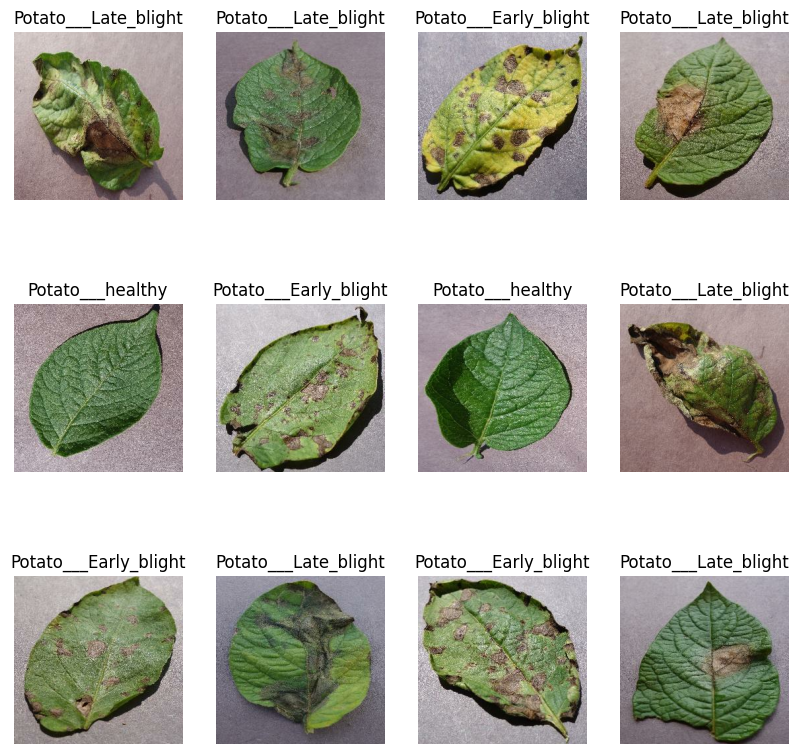

In [21]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]]) #use class names otherwise it will show only 0, 1 or 2
        plt.axis("off")
    

In [22]:
len(dataset)

68

80% ==> training

20% ==> 10% validation, 10% test
#after every epoch, run validation; after that, the test

In [25]:
train_size = 0.8
len(dataset)*train_size


54.400000000000006

In [32]:
train_ds = dataset.take(54)
len(train_ds)

54

In [27]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [28]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [30]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [31]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [35]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):  #shuffle reduces overfitting and bias
    ds_size = len(ds) #68
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split*ds_size) # 0.8*68 = 54
    val_size = int(val_split*ds_size) # 0.1*68 = 6.8 
    
    train_ds = ds.take(train_size) #take(54)
    
    val_ds = ds.skip(train_size).take(val_size) #skip(54), take(6)
    test_ds = ds.skip(train_size).skip(val_size) #skip(54), skip(6)
    
    
    return train_ds, val_ds, test_ds

In [37]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf (dataset)

In [38]:
len(train_ds)

54

In [39]:
len(val_ds)

6

In [40]:
len(test_ds)

8

Prepare the training, validation, and test datasets
- Cache: Stores the data in memory after the first time it is read
- Shuffle: Randomly shuffles the data with a buffer size of 1000
- Prefetch: Allows the data to be fetched in parallel to model training, improving performance

In [41]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


In [46]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential

Layer Imports: Necessary imports for building the neural network model are included, specifically importing layers and the Sequential model from TensorFlow.

Resize and Rescale: A Sequential model is defined to resize images to a uniform size and rescale pixel values for normalization.

Data Augmentation: Another Sequential model is defined for data augmentation, which includes random flipping and rotation of images to make the model more robust by learning from varied inputs.

In [48]:
# Define a Sequential model to resize and rescale the images
# - Resizing: Adjusts images to the defined IMAGE_SIZE
# - Rescaling: Normalizes pixel values to the range [0, 1] by dividing by 255


resize_and_rescale = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255),
])

In [50]:
# Define data augmentation steps to improve model generalization
# - RandomFlip: Randomly flips the images horizontally and vertically
# - RandomRotation: Randomly rotates the images by 20% of a full circle

data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

The model architecture includes resizing, rescaling, and data augmentation layers for preprocessing, followed by multiple convolutional layers with ReLU activation and max-pooling for feature extraction. 

The output is flattened and passed through a dense layer before reaching the final softmax-activated output layer for classification. Finally, the model is built based on the defined input shape:

In [52]:
import warnings
warnings.filterwarnings('ignore')



input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


          
    

In [53]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Compile the model with the specified optimizer, loss function, and evaluation metrics

model.compile(
    optimizer = 'adam', # Adam optimizer is used for efficient gradient-based optimization
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), # Loss function for multi-class classification
    metrics = ["accuracy"]
)

In [56]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1, # Print progress to the console during training
    validation_data = val_ds # Validation dataset for monitoring performance
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 431ms/step - accuracy: 0.4512 - loss: 0.9336 - val_accuracy: 0.5000 - val_loss: 0.7724
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 421ms/step - accuracy: 0.6206 - loss: 0.7798 - val_accuracy: 0.7917 - val_loss: 0.4660
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 407ms/step - accuracy: 0.7830 - loss: 0.5175 - val_accuracy: 0.8385 - val_loss: 0.3394
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 409ms/step - accuracy: 0.8018 - loss: 0.4458 - val_accuracy: 0.8177 - val_loss: 0.4113
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 413ms/step - accuracy: 0.8642 - loss: 0.3785 - val_accuracy: 0.9062 - val_loss: 0.2633
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 395ms/step - accuracy: 0.8861 - loss: 0.2888 - val_accuracy: 0.9271 - val_loss: 0.2062
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 394ms/step - accuracy: 0.9169 - loss: 0.2175 - val_accuracy: 0.9062 - val_loss: 0.2299
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 393ms/step - accuracy: 0.9144 - loss: 0.2297 - val_accu

In [57]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9896 - loss: 0.0391


In [58]:
scores

[0.043119702488183975, 0.984375]

In [60]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [61]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [65]:
# Extract the accuracy and loss values for both training and validation from the training history
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training and Validation Accuracy')

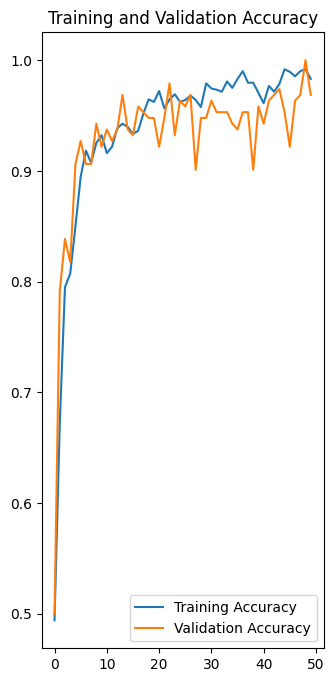

In [66]:
# Plot training and validation accuracy over epochs
# 
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



Both accuracies follow a similar trend, which is a good sign that the model is learning effectively and is not overfitting too much.

If the training accuracy is much higher than the validation accuracy, it could indicate overfitting, where the model performs well on training data but poorly on unseen data.

However, in this case, both accuracies are relatively close, suggesting a well-balanced model that generalizes reasonably well to new data.

The output below is a series of nested lists, where each sublist represents a row of pixels in the image.
Each number within these sublists represents the intensity value of a pixel.
For a grayscale image, you would see single values per pixel.
For a color image (RGB), each pixel would be represented by three values (one for each channel: Red, Green, and Blue).

In [69]:
for images_batch, labels_batch in test_ds.take(1):
    print(images_batch[0].numpy().astype('uint8'))
    #Changes the data type: The .astype('uint8') method changes the data type of the array to unsigned 8-bit integer, which is commonly used for image data (with values ranging from 0 to 255).
    #The output is a 3D array representing the pixel values of the image. Each element in the array corresponds to a pixel value in the image, with the dimensions corresponding to the height, width, and color channels (for RGB images).

[[[167 174 193]
  [163 170 189]
  [159 166 185]
  ...
  [109 112 131]
  [115 118 137]
  [108 111 130]]

 [[160 167 186]
  [159 166 185]
  [160 167 186]
  ...
  [113 116 135]
  [121 124 143]
  [126 129 148]]

 [[161 168 187]
  [161 168 187]
  [161 168 187]
  ...
  [109 112 131]
  [114 117 136]
  [124 127 146]]

 ...

 [[167 171 183]
  [170 174 186]
  [172 176 188]
  ...
  [122 124 136]
  [125 127 139]
  [129 131 143]]

 [[162 166 178]
  [165 169 181]
  [169 173 185]
  ...
  [129 131 143]
  [130 132 144]
  [130 132 144]]

 [[159 163 175]
  [164 168 180]
  [168 172 184]
  ...
  [131 133 145]
  [129 131 143]
  [123 125 137]]]


In [77]:
import numpy as np

np.argmax([9.9999988e-01,1.1716658e-07,2.1643424e-17])
#this will show the class based on the below prediction. the 9.999 are the predicted batches (pixels)

0

first image to predict
first image's actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
predicted label: Potato___Late_blight


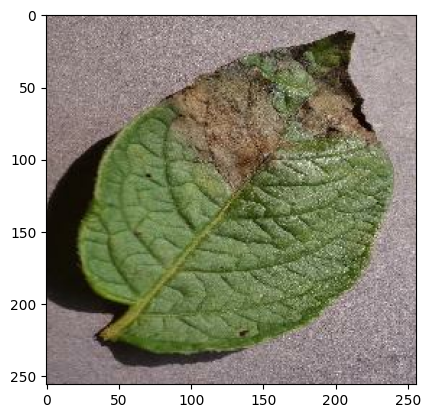

In [86]:


for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])


In [102]:
def predict(model, img):
     # Convert the image to an array
    # tf.keras.preprocessing.image.img_to_array converts an image instance to a numpy array
    # This step is necessary to ensure the image is in the right format for the model
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    # Expand the dimensions of the image array to create a batch
    # tf.expand_dims adds an extra dimension at the axis specified (axis 0 here)
    # The model expects a batch of images, even if it's just one image


    # model.predict processes the image batch and returns predictions
    # The output 'predictions' is an array of probabilities for each class
    predictions = model.predict(img_array)

    # np.max(predictions[0]) finds the highest probability in the predictions array
    # Multiply by 100 to get the percentage confidence and round to 2 decimal places
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


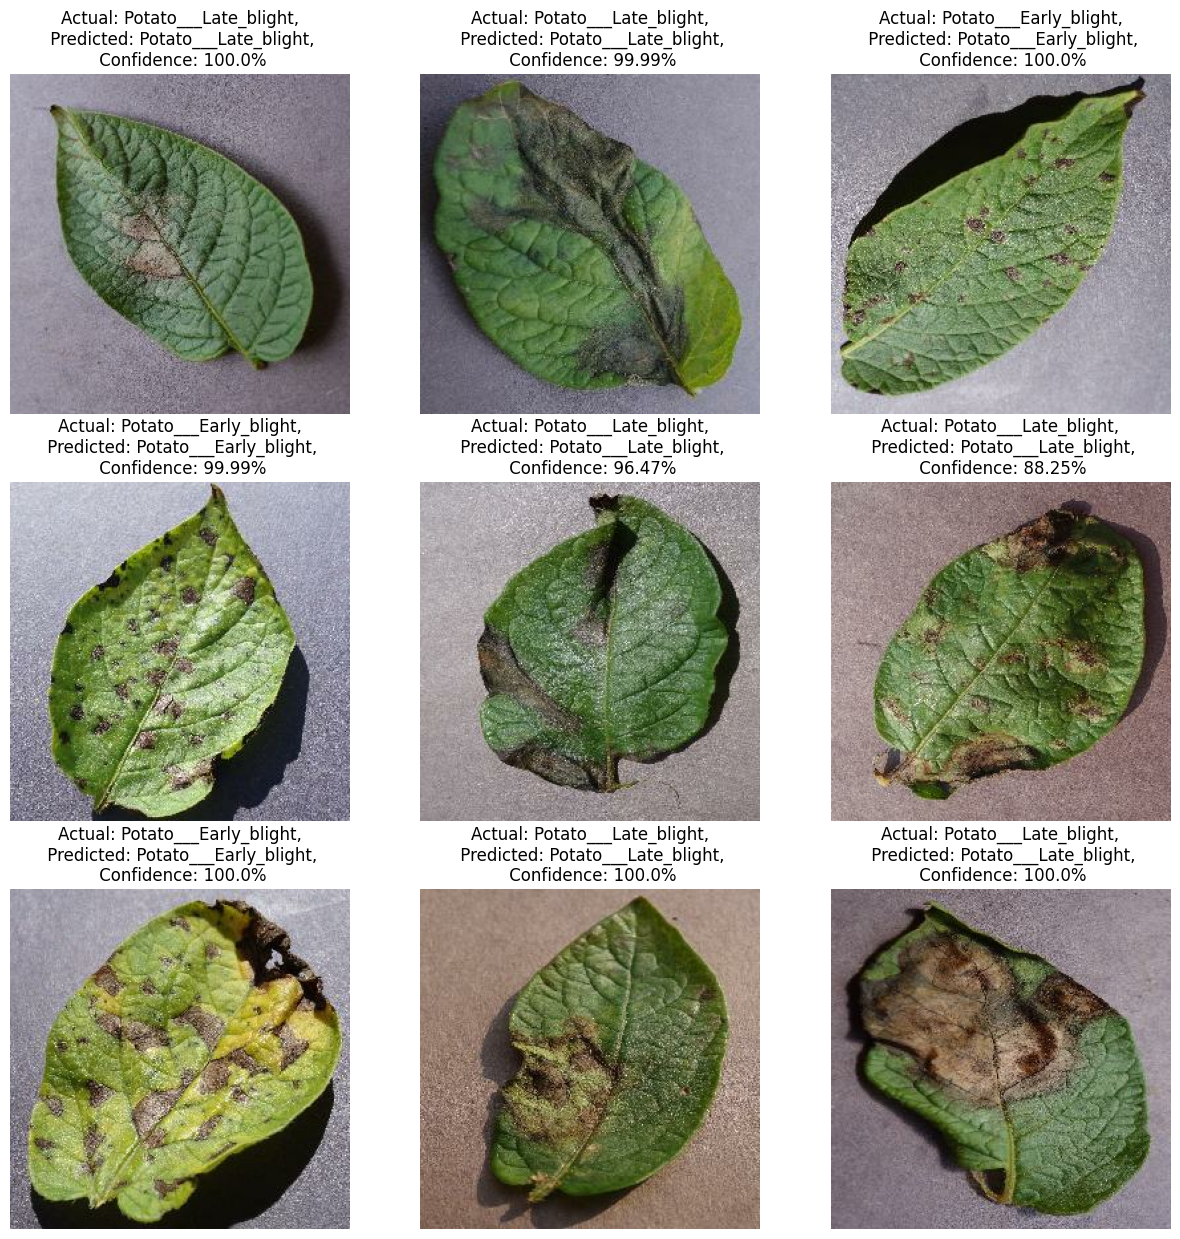

In [103]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        img = images[i].numpy()
        predicted_class, confidence = predict(model, img)
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")
        plt.axis("off")

plt.show()



        

In [113]:
model_version = 1
model.save(f"C:/Users/polin/Downloads/potato-disease/models/{model_version}.keras")